# Pasos Previos

In [1]:
# Cargamos todas las librerías necesarias

## Básicas
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis de Multicolinealidad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

## Preparación
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

## Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid

# Validación y métricas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from itertools import product


## Generación del archivo csv que necesitaremos

In [2]:
# Importamos el JSON

url='https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'

response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)

In [3]:
df_plano = pd.json_normalize(data)
df_plano

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90,267.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,No,Female,0,No,No,13,Yes,No,DSL,...,No,No,Yes,No,No,One year,No,Mailed check,55.15,742.9
7263,9992-RRAMN,Yes,Male,0,Yes,No,22,Yes,Yes,Fiber optic,...,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.10,1873.7
7264,9992-UJOEL,No,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,50.30,92.75
7265,9993-LHIEB,No,Male,0,Yes,Yes,67,Yes,No,DSL,...,No,Yes,Yes,No,Yes,Two year,No,Mailed check,67.85,4627.65


In [4]:
df_plano.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [5]:
df_plano.apply(lambda x: x.astype(str).str.strip()=='').sum()

,0
customerID,0
Churn,224
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [6]:
# Cambiando la columna "account.Charges.Total" a Float

df_plano['account.Charges.Total'] = pd.to_numeric(df_plano['account.Charges.Total'], errors='coerce')
print(df_plano['account.Charges.Total'].dtype)

float64


In [7]:
# Eliminando las columnas de Churn

df_plano = df_plano[df_plano['Churn'].str.strip() != '']
print("Número de filas después de eliminar las vacías en 'Churn':", len(df_plano))

Número de filas después de eliminar las vacías en 'Churn': 7043


In [8]:
# Verificamos vacíos o en blanco
df_plano.apply(lambda x: x.astype(str).str.strip() == '').sum()

,0
customerID,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [9]:
df_plano.describe()

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [10]:
df_plano['Total.Day'] = ((df_plano['account.Charges.Total'] /  df_plano['customer.tenure']) / 30).round(2)

/tmp/ipython-input-625968312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plano['Total.Day'] = ((df_plano['account.Charges.Total'] /  df_plano['customer.tenure']) / 30).round(2)


In [11]:
df_plano.columns

Index(['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total', 'Total.Day'],
      dtype='object')

In [12]:
df_plano.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   int64  
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   int64  
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   object 
 1

In [13]:
# Movemos la columna 'Total.Day'
df_plano.insert(19, 'Total.Day',  df_plano.pop('Total.Day'))

In [14]:
# Verificamos...
df_plano.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   int64  
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   int64  
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   object 
 1

In [15]:
# Finalmente, generamos el csv que necesitamos
df_plano.to_csv("datos_tratados.csv", index=False)

# 🎯 La Misión

Tu nueva misión es desarrollar modelos predictivos capaces de __prever qué clientes tienen mayor probabilidad de cancelar sus servicios__ (churn).

La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.


# Procesamiento del archivo csv para Challenge Parte 2

## Leemos el archivo

In [16]:
df = pd.read_csv('/content/datos_tratados.csv')

In [17]:
df.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,Total.Day,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,2.20,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,2.01,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,2.34,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.17,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.97,83.9,267.40


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   int64  
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   int64  
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   objec

## 🛠️ Preparación de los Datos##


In [19]:
df.columns

Index(['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod', 'Total.Day',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')

In [20]:
# Eliminación de Columnas Irrelevantes
# el Id del cliente no tiene ninguna relevancia para entrenar nuestros modelos, no es un dato que se correlacione con la variable objetivo, por lo que NO es un feature.

df = df.drop(columns=["customerID"])

In [21]:
df.columns

Index(['Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod', 'Total.Day',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')

In [22]:
# para crear un nuevo DF
df_clean = df.copy()

cols_to_fix = [
    'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
    'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies'
]

# === Etapa 1: Agrupar "No internet service" como "No"
for col in cols_to_fix:
    df_clean[col] = df_clean[col].replace('No internet service', 'No')

# === Etapa 2: One-hot encoding (sin dummy trap)
categorical_cols = [
       'Churn', 'customer.gender', 'customer.Partner', 'customer.Dependents',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod'
]

df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# ¡Listo para usar!
df_encoded

,customer.SeniorCitizen,customer.tenure,Total.Day,account.Charges.Monthly,account.Charges.Total,Churn_Yes,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0,9,2.20,65.60,593.30,False,False,True,True,True,...,False,True,True,False,True,False,True,False,False,True
1,0,9,2.01,59.90,542.40,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0,4,2.34,73.90,280.85,True,True,False,False,True,...,True,False,False,False,False,False,True,False,True,False
3,1,13,3.17,98.00,1237.85,True,True,True,False,True,...,True,False,True,True,False,False,True,False,True,False
4,1,3,2.97,83.90,267.40,True,False,True,False,True,...,False,True,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,13,1.90,55.15,742.90,False,False,False,False,True,...,False,True,False,False,True,False,False,False,False,True
7039,0,22,2.84,85.10,1873.70,True,True,True,False,True,...,False,False,False,True,False,False,True,False,True,False
7040,0,2,1.55,50.30,92.75,False,True,False,False,True,...,False,False,False,False,False,False,True,False,False,True
7041,0,67,2.30,67.85,4627.65,False,True,True,True,True,...,True,True,False,True,False,True,False,False,False,True


## Verificación nuevamente de los valores nulos

In [23]:
df_encoded.isnull().sum()

,0
customer.SeniorCitizen,0
customer.tenure,0
Total.Day,11
account.Charges.Monthly,0
account.Charges.Total,11
Churn_Yes,0
customer.gender_Male,0
customer.Partner_Yes,0
customer.Dependents_Yes,0
phone.PhoneService_Yes,0


In [24]:
# Verifica valores nulos en las dos columnas
print(df_encoded[['Total.Day', 'account.Charges.Total']].isnull().sum())

Total.Day                11
account.Charges.Total    11
dtype: int64


In [25]:
# Elimina filas con valores nulos en las columnas especificadas
df_encoded = df_encoded.dropna(subset=['Total.Day', 'account.Charges.Total'])

In [26]:
df_encoded.isnull().sum()

,0
customer.SeniorCitizen,0
customer.tenure,0
Total.Day,0
account.Charges.Monthly,0
account.Charges.Total,0
Churn_Yes,0
customer.gender_Male,0
customer.Partner_Yes,0
customer.Dependents_Yes,0
phone.PhoneService_Yes,0


## Normalización/Estandarización

In [27]:
# Seleccionando solo columnas numéricas (excepto la variable target, si ya está separada)
columnas_numericas = df_encoded.select_dtypes(include=['int64', 'float64']).columns

# Inicializando el scaler
scaler = MinMaxScaler()

# Aplicando la normalización
df_encoded[columnas_numericas] = scaler.fit_transform(df_encoded[columnas_numericas])

# Mostrando los datos normalizados
df_encoded.head()

/tmp/ipython-input-784306299.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[columnas_numericas] = scaler.fit_transform(df_encoded[columnas_numericas])


,customer.SeniorCitizen,customer.tenure,Total.Day,account.Charges.Monthly,account.Charges.Total,Churn_Yes,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0.0,0.112676,0.484680,0.471144,0.066294,False,False,True,True,True,...,False,True,True,False,True,False,True,False,False,True
1,0.0,0.112676,0.431755,0.414428,0.060420,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0.0,0.042254,0.523677,0.553731,0.030239,True,True,False,False,True,...,True,False,False,False,False,False,True,False,True,False
3,1.0,0.169014,0.754875,0.793532,0.140670,True,True,True,False,True,...,True,False,True,True,False,False,True,False,True,False
4,1.0,0.028169,0.699164,0.653234,0.028687,True,False,True,False,True,...,False,True,True,False,False,False,True,False,False,True


In [28]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   customer.SeniorCitizen                         7032 non-null   float64
 1   customer.tenure                                7032 non-null   float64
 2   Total.Day                                      7032 non-null   float64
 3   account.Charges.Monthly                        7032 non-null   float64
 4   account.Charges.Total                          7032 non-null   float64
 5   Churn_Yes                                      7032 non-null   bool   
 6   customer.gender_Male                           7032 non-null   bool   
 7   customer.Partner_Yes                           7032 non-null   bool   
 8   customer.Dependents_Yes                        7032 non-null   bool   
 9   phone.PhoneService_Yes                         7032 non-n

## Correlación entre las variables

In [29]:
corr = df_encoded.corr()

In [30]:
corr

,customer.SeniorCitizen,customer.tenure,Total.Day,account.Charges.Monthly,account.Charges.Total,Churn_Yes,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
customer.SeniorCitizen,1.000000,0.015683,0.217622,0.219874,0.102411,0.150541,-0.001819,0.016957,-0.210550,0.008392,...,0.059514,-0.060577,0.105445,0.119842,-0.046491,-0.116205,0.156258,-0.024359,0.171322,-0.152987
customer.tenure,0.015683,1.000000,0.246210,0.246862,0.825880,-0.354049,0.005285,0.381912,0.163386,0.007877,...,0.361520,0.325288,0.280264,0.285402,0.202338,0.563801,0.004823,0.232800,-0.210197,-0.232181
Total.Day,0.217622,0.246210,1.000000,0.996227,0.650921,0.192030,-0.014477,0.097159,-0.112514,0.247900,...,0.481736,0.338021,0.626474,0.626058,0.005252,-0.072454,0.349467,0.029974,0.270270,-0.374906
account.Charges.Monthly,0.219874,0.246862,0.996227,1.000000,0.651065,0.192858,-0.013779,0.097825,-0.112343,0.248033,...,0.482607,0.338301,0.629668,0.627235,0.004810,-0.073256,0.351930,0.030055,0.271117,-0.376568
account.Charges.Total,0.102411,0.825880,0.650921,0.651065,1.000000,-0.199484,0.000048,0.319072,0.064653,0.113008,...,0.522881,0.432868,0.515709,0.519867,0.170569,0.358036,0.157830,0.182663,-0.060436,-0.294708
Churn_Yes,0.150541,-0.354049,0.192030,0.192858,-0.199484,1.000000,-0.008545,-0.149982,-0.163128,0.011691,...,-0.066193,-0.164716,0.063254,0.060860,-0.178225,-0.301552,0.191454,-0.134687,0.301455,-0.090773
customer.gender_Male,-0.001819,0.005285,-0.014477,-0.013779,0.000048,-0.008545,1.000000,-0.001379,0.010349,-0.007515,...,-0.000807,-0.008507,-0.007124,-0.010105,0.007755,-0.003603,-0.011902,0.001632,0.000844,0.013199
customer.Partner_Yes,0.016957,0.381912,0.097159,0.097825,0.319072,-0.149982,-0.001379,1.000000,0.452269,0.018397,...,0.153556,0.120206,0.124483,0.118108,0.083067,0.247334,-0.013957,0.082327,-0.083207,-0.096948
customer.Dependents_Yes,-0.210550,0.163386,-0.112514,-0.112343,0.064653,-0.163128,0.010349,0.452269,1.000000,-0.001078,...,0.013900,0.063053,-0.016499,-0.038375,0.069222,0.201699,-0.110131,0.061134,-0.149274,0.056448
phone.PhoneService_Yes,0.008392,0.007877,0.247900,0.248033,0.113008,0.011691,-0.007515,0.018397,-0.001078,1.000000,...,-0.070076,-0.095138,-0.021383,-0.033477,-0.003142,0.004442,0.016696,-0.006916,0.002747,-0.004463


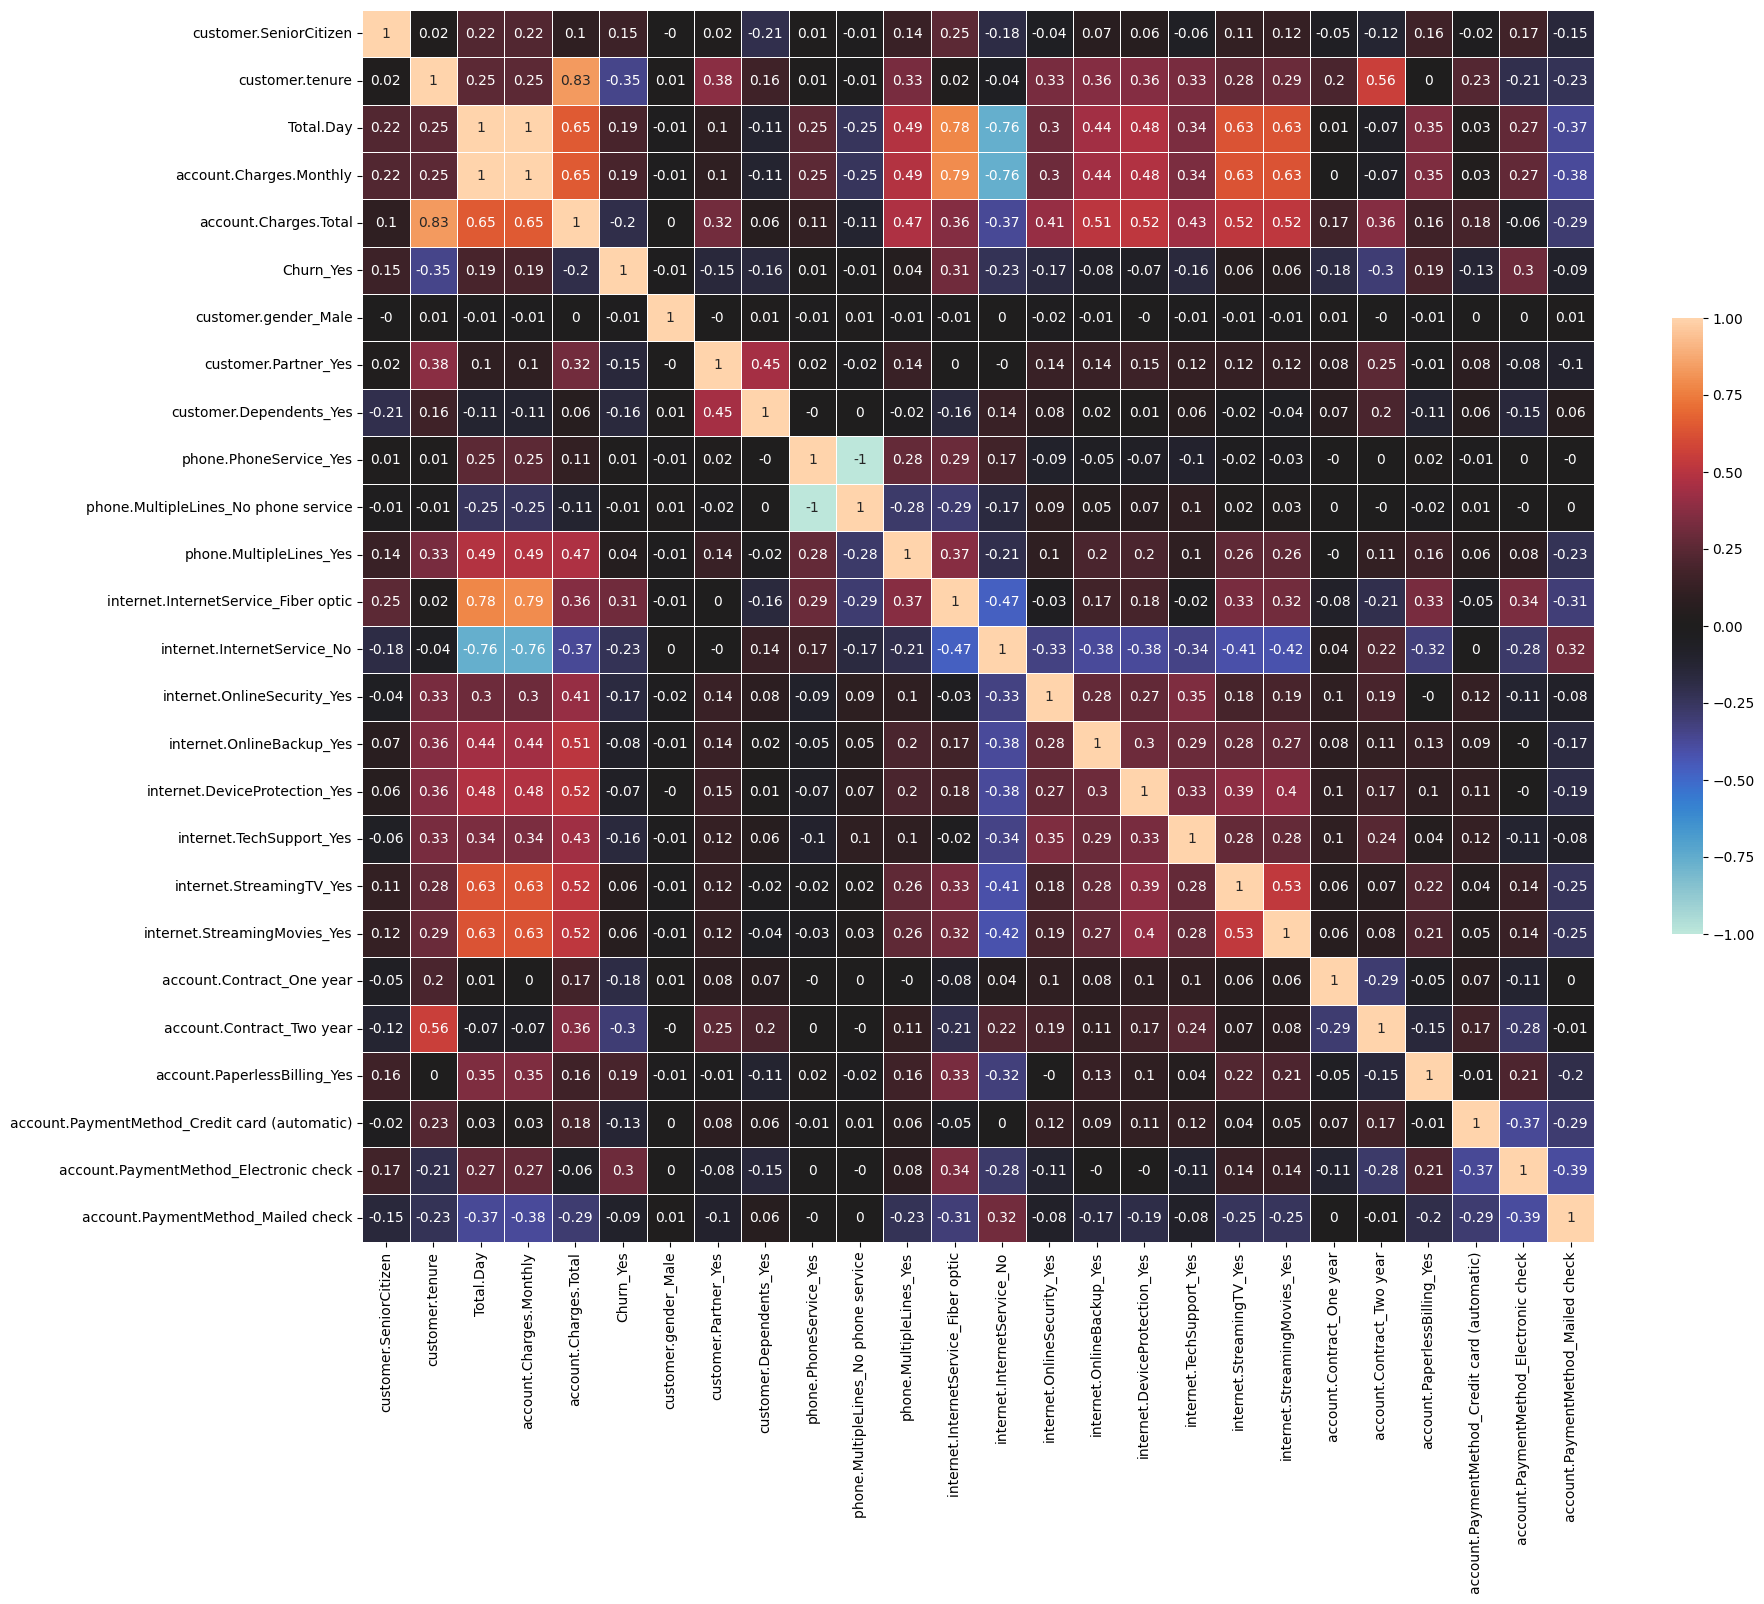

In [31]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()

In [32]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   customer.SeniorCitizen                         7032 non-null   float64
 1   customer.tenure                                7032 non-null   float64
 2   Total.Day                                      7032 non-null   float64
 3   account.Charges.Monthly                        7032 non-null   float64
 4   account.Charges.Total                          7032 non-null   float64
 5   Churn_Yes                                      7032 non-null   bool   
 6   customer.gender_Male                           7032 non-null   bool   
 7   customer.Partner_Yes                           7032 non-null   bool   
 8   customer.Dependents_Yes                        7032 non-null   bool   
 9   phone.PhoneService_Yes                         7032 non-n

##  Análisis de Multicolinealidad

In [33]:
# Seleccionar las variables independientes
# Aquí, no incluyas la variable objetivo (ej: Churn\_Yes) en el cálculo del VIF.

X = df_encoded.drop(columns=['Churn_Yes'])

In [34]:
#Añadir constante (intercepto)
X_const = add_constant(X)

# Reemplazar infinitos por NaN
X_const = X_const.replace([np.inf, -np.inf], np.nan)

# Eliminar filas con NaN
X_const = X_const.dropna()

In [35]:
# Calcular el VIF
# Convertir columnas boolean a enteros (0 or 1)
X_const = X_const.astype(float)

# Calcular el VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Mostrar resultado
display(vif_data.sort_values(by='VIF', ascending=False))

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
9,phone.PhoneService_Yes,inf
10,phone.MultipleLines_No phone service,inf
4,account.Charges.Monthly,893.801679
12,internet.InternetService_Fiber optic,148.489528
3,Total.Day,133.569255
13,internet.InternetService_No,104.213964
19,internet.StreamingMovies_Yes,24.155141
18,internet.StreamingTV_Yes,24.033815
5,account.Charges.Total,10.871303
2,customer.tenure,7.613409


In [36]:
# Eliminamos columna "phone.PhoneService_Yes"
df_encoded.drop(columns=["phone.PhoneService_Yes"], inplace=True)

/tmp/ipython-input-3800610168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded.drop(columns=["phone.PhoneService_Yes"], inplace=True)


In [37]:
# Verificar y eliminar columnas:Charges.Monthly, Charges.Total y Total.Day
#df_encoded.drop(columns=["account.Charges.Monthly", "account.Charges.Total", "Total.Day"], inplace=True)


In [38]:
# Mantener solo una de las variables entre InternetService_Fiber optic, InternetService_No
# df_encoded.drop(columns=["internet.InternetService_Fiber optic"], inplace=True)


In [39]:
# Eliminamos columnas adicionales

df_encoded.drop(columns=["phone.MultipleLines_No phone service"], inplace=True)
df_encoded.drop(columns=["Total.Day"], inplace=True)

/tmp/ipython-input-3640102906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded.drop(columns=["phone.MultipleLines_No phone service"], inplace=True)
/tmp/ipython-input-3640102906.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded.drop(columns=["Total.Day"], inplace=True)


In [40]:
#Evaluar si es necesario mantener todas las variables derivadas de internet (streaming, seguridad, etc.).
#Verificar si Charges.Total puede ser recalculado, si ya existen Monthly y tenure.

In [41]:
# Verificamos nuevamente el VIF

X = df_encoded.drop(columns=['Churn_Yes'])
# Añadir constante (intercepto)
X_const = add_constant(X)

# Reemplazar infinitos por NaN
X_const = X_const.replace([np.inf, -np.inf], np.nan)

# Eliminar filas con NaN
X_const = X_const.dropna()
#Calcular el VIF
# Convert boolean columns to integers (0 or 1)
X_const = X_const.astype(float)

# Calcular el VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Mostrar resultado
display(vif_data.sort_values(by='VIF', ascending=False))


,feature,VIF
0,const,36.750242
3,account.Charges.Monthly,35.340431
4,account.Charges.Total,10.810996
9,internet.InternetService_Fiber optic,10.115348
2,customer.tenure,7.584286
10,internet.InternetService_No,4.845675
18,account.Contract_Two year,2.652127
15,internet.StreamingTV_Yes,2.454781
16,internet.StreamingMovies_Yes,2.434019
21,account.PaymentMethod_Electronic check,1.976032


In [42]:
# La columna "account.Charges.Total" aún tiene un VIF muy alto, también la eliminamos...
df_encoded.drop(columns=["account.Charges.Total"], inplace=True)

/tmp/ipython-input-751273153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded.drop(columns=["account.Charges.Total"], inplace=True)


In [43]:
# Verificamos nuevamente el VIF...

X = df_encoded.drop(columns=['Churn_Yes'])
# Añadir constante (intercepto)
X_const = add_constant(X)

# Reemplazar infinitos por NaN
X_const = X_const.replace([np.inf, -np.inf], np.nan)

# Eliminar filas con NaN
X_const = X_const.dropna()
#Calcular el VIF
# Convert boolean columns to integers (0 or 1)
X_const = X_const.astype(float)

# Calcular el VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Mostrar resultado
display(vif_data.sort_values(by='VIF', ascending=False))


,feature,VIF
3,account.Charges.Monthly,33.535952
0,const,30.981951
8,internet.InternetService_Fiber optic,10.109891
9,internet.InternetService_No,4.798973
2,customer.tenure,2.826855
17,account.Contract_Two year,2.633106
14,internet.StreamingTV_Yes,2.445428
15,internet.StreamingMovies_Yes,2.422864
20,account.PaymentMethod_Electronic check,1.973728
7,phone.MultipleLines_Yes,1.924197


## Conclusión

Aún la columna "account.Charges.Monthly" posee un VIF mayor de lo deseado, eventualmente esta columna deberá ser eliminada o recalculada, lo dejamos para más adelante...

##  Modelos Predictivos

In [44]:
# Separar features y target... se viene lo bueno!

X = df_encoded.drop(columns=['Churn_Yes'])
y = df_encoded['Churn_Yes']

In [45]:
# Dividimos entrenamiento y prueba: 30% Testing, 70% Training

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Observación: necesitamos aplicar shuffle?

**Normalizar**

In [46]:
# Aplicamos Scaler para los modelos que lo requieren, qué sensibles!!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Balancear entrenamiento con SMOTE**

Estas son pruebas iniciales, más adelante nos daremos cuenta que necesitamos automatizar este proceso para realizar un óptimo Grid Search!

In [47]:
# Balancear con SMOTE (solo en train)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

In [48]:
print("Distribución antes de SMOTE:", y_train.value_counts().to_dict())
print("Distribución después de SMOTE:", {0: sum(y_train_bal==0), 1: sum(y_train_bal==1)})


Distribución antes de SMOTE: {False: 3614, True: 1308}
Distribución después de SMOTE: {0: 3614, 1: 3614}



Matriz de confusión:
 [[1138  411]
 [ 123  438]]

Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.90      0.73      0.81      1549
        True       0.52      0.78      0.62       561

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.76      2110

ROC AUC: 0.8424059452996526


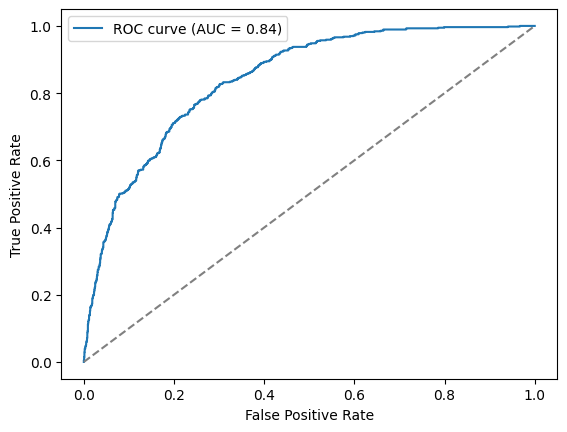

In [49]:
# Entrenar el modelo y evauar méricas

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_bal, y_train_bal)

# Evaluar en test (sin SMOTE)
y_pred = log_reg.predict(X_test_scaled)
y_proba_smote = log_reg.predict_proba(X_test_scaled)[:,1]

print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba_smote))

# Curva ROC
## ROC significa Receiver Operating Characteristic (en español: Característica Operativa del Receptor)
fpr, tpr, _ = roc_curve(y_test, y_proba_smote)
plt.plot(fpr, tpr, label="ROC curve (AUC = %.2f)" % roc_auc_score(y_test, y_proba_smote))
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



## ¿Qué significa ROC?

**ROC** significa **Receiver Operating Characteristic** (*Característica Operativa del Receptor*).

Es una curva utilizada para evaluar el rendimiento de un modelo de **clasificación binaria**, especialmente útil cuando las clases están desequilibradas.

---

### 🔍 ¿Qué muestra la curva ROC?

La curva ROC representa el comportamiento del modelo al variar el umbral de decisión. Traza dos métricas clave:

- **Eje X:** Tasa de falsos positivos (**FPR** – *False Positive Rate*)  
  `FPR = FP / (FP + TN)`

- **Eje Y:** Tasa de verdaderos positivos (**TPR** – *True Positive Rate* o *Recall*)  
  `TPR = TP / (TP + FN)`

Cada punto de la curva corresponde a un umbral distinto de clasificación.

---

### ✅ ¿Qué tan buena es una curva ROC?

- Una curva más cerca del **vértice superior izquierdo** indica un mejor modelo.
- El área bajo la curva (**AUC**, por *Area Under the Curve*) resume el rendimiento general:

| AUC Score | Interpretación           |
|-----------|--------------------------|
| 0.90 – 1  | Excelente                 |
| 0.80 – 0.90 | Muy bueno / Bueno       |
| 0.70 – 0.80 | Aceptable               |
| 0.60 – 0.70 | Pobre                   |
| 0.50 – 0.60 | Muy pobre / Aleatorio  |
---

### 📊 ¿Por qué es útil?

La curva ROC es útil porque:

- Es independiente del umbral de decisión.
- Funciona bien incluso con clases desbalanceadas.
- Permite

---

### Finalmente, un ROC AUC de 0.838 indica:
- El modelo **discrimina bien entre clases**, lo que lo hace útil para tareas donde se necesita priorizar la detección precisa.
- No es perfecto, pero sí confiable para muchas aplicaciones.

> ⚠️ Importante: un buen AUC no garantiza que otras métricas como **precisión**, **recall** o **F1-score** también sean altas. Siempre es recomendable analizar múltiples métricas para una evaluación completa.


## Conclusión (parcial)

## 🎯 Análisis de la Matriz de Confusión (Cancelación de Clientes)

### Objetivo del Modelo
Prever qué clientes tienen **mayor probabilidad de cancelar sus servicios (churn)**, con el fin de aplicar medidas preventivas.

---

### 📊 Matriz de Confusión

|                          | Predicho: No Cancela (0) | Predicho: Cancela (1) |
|--------------------------|--------------------------|------------------------|
| **Real: No Cancela (0)** | 1119 (TN)                | 430 (FP)              |
| **Real: Cancela (1)**    | 122 (FN)                 | 439 (TP)              |

---

### 🧠 Interpretación

- **TP (439)** – Clientes que **sí cancelaron** y fueron **detectados correctamente**.
- **FN (122)** – Clientes que **sí cancelaron** pero **no fueron detectados**.  
  ⚠️ **Muy importante reducir este valor.**
- **FP (430)** – Clientes que **no cancelaron** pero el modelo predijo que sí.  
  🟡 Puede llevar a intervenciones innecesarias.
- **TN (1119)** – Clientes que **no cancelaron** y fueron correctamente ignorados.

---

### 📈 Métricas Relevantes

| Métrica      | Fórmula                                               | Resultado | Interpretación |
|--------------|--------------------------------------------------------|-----------|----------------|
| **Recall**   | `TP / (TP + FN) = 439 / (439 + 122)`                  | ≈ `0.78`  | El **78% de los clientes que cancelaron fueron detectados**. |
| **Precision**| `TP / (TP + FP) = 439 / (439 + 430)`                  | ≈ `0.505` | Solo el **50.5% de los alertados realmente cancelan**. |
| **Accuracy** | `(TP + TN) / Total = (439 + 1119) / 2110`             | ≈ `0.736` | Precisión general del modelo. |
| **F1-score** | `2 * (Precision * Recall) / (Precision + Recall)`     | ≈ `0.613`         | Balance entre precision y recall.  |

---

### ✅ Recomendaciones Estratégicas

1. **Reducir los False Negatives (FN)**:  
   - Estos representan clientes que **cancelaron sin haber sido detectados**.
   - Ajustar el umbral del modelo puede aumentar la sensibilidad (**recall**).

2. **Analizar los False Positives (FP)**:  
   - Clientes que **no iban a cancelar**, pero fueron erróneamente marcados.
   - Investigar si hay patrones comunes (segmentos, productos, etc.).

3. **Segmentar las alertas por probabilidad de churn**:  
   - Alta probabilidad → Contacto proactivo.
   - Media probabilidad → Incentivos o monitoreo.
   - Baja probabilidad → Sin intervención inmediata.

---



## 📌 Conclusión Importante

Para problemas de churn, donde es **más costoso perder clientes sin prevenirlo** (False Negative), priorizar el **Recall** es la estrategia inicial a seguir y, por lo tanto, debiese ser la principal métrica a considerar para evaluar el mejor modelo.

Otra forma de ver, el **Recall** es la mayor cantidad de clientes que sí van a cancelar (clase positiva `1`), es decir, esta es la métrica que debemos maximizar, entonces, según la fórmula del Recall [TP / (TP + FN)], se debe encontrar un modelo con alto TP (True Positive: detección correcta de clientes que van a cancelar) y bajo FN (False Negative: clientes que sí van a cancelar, pero que el modelo no los detecta).




## IMPORTANTE: Grid Search

Tras este análisis nos hacemos la siguiente pregunta, lograremos mejores resultados con otros hiperparámetros?
Actualmente usamos max_iter=1000 y random_state=42, podemos averiguar cuáles son los rangos óptimos de estos parámetros (min/max), esto genera una matriz MxN de posibles combinaciones (2 dimensiones por ser dos hiperparámetros), por lo tanto, es primordial poder evaluar todos estos hiperparámetros para detectar el **modelo óptimo**, pero hacer esto en forma manual es imposible, por ello, más adelante deberemos implementar la funcionalidad Grid Search automatizada, es decir, una función python que evalúe automáticamente (genere, entrene y valide las métricas) los modelos que se pueden obtener con la combinación de hiperparámetros.

Por ahora, evaluaremos otras alternativas a SMOTE como algoritmo de balanceo.

## Modelo SMOTEENN


Matriz de confusión:
 [[982 567]
 [ 68 493]]

Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.94      0.63      0.76      1549
        True       0.47      0.88      0.61       561

    accuracy                           0.70      2110
   macro avg       0.70      0.76      0.68      2110
weighted avg       0.81      0.70      0.72      2110

ROC AUC: 0.8379628510832703


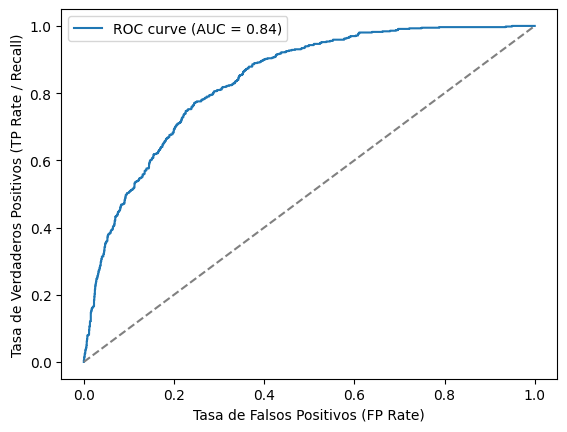

In [50]:
''' Esto no lo haremos, ya que usaremos el mismo set de datos que usamos para el SMOTE, peras con peras pue!
# División de datos y escalado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
'''

# Aplicar SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_bal, y_train_bal = smote_enn.fit_resample(X_train_scaled, y_train)

# Entrenar modelo
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_bal, y_train_bal)

# Evaluar en test
y_pred = log_reg.predict(X_test_scaled)
y_proba_smoteenn = log_reg.predict_proba(X_test_scaled)[:, 1]

# Reportes
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba_smoteenn))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_smoteenn)
plt.plot(fpr, tpr, label="ROC curve (AUC = %.2f)" % roc_auc_score(y_test, y_proba_smoteenn))
plt.plot([0,1],[0,1],'--',color='gray')
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")
# reemplazamos por nombres específicos
plt.xlabel("Tasa de Falsos Positivos (FP Rate)")
plt.ylabel("Tasa de Verdaderos Positivos (TP Rate / Recall)")
plt.legend()
plt.show()


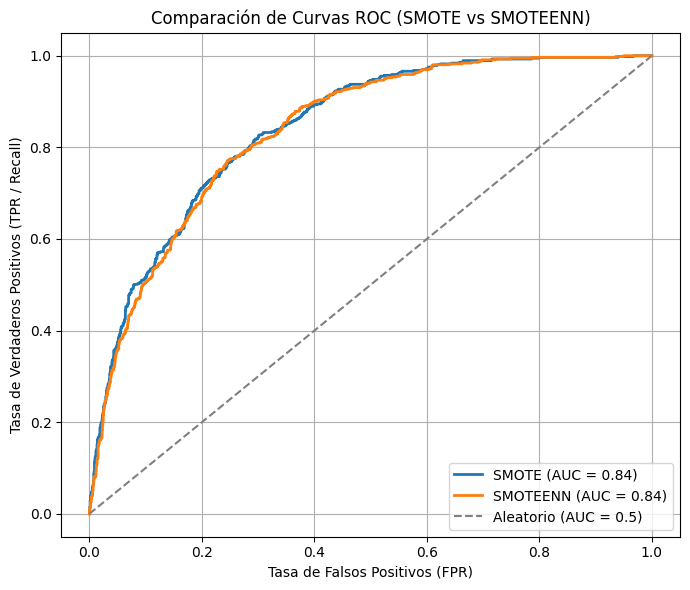

In [51]:
# **Graficar ambas curvas ROC**

# Curvas ROC
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_proba_smote)
fpr_smoteenn, tpr_smoteenn, _ = roc_curve(y_test, y_proba_smoteenn)

# AUCs
auc_smote = roc_auc_score(y_test, y_proba_smote)
auc_smoteenn = roc_auc_score(y_test, y_proba_smoteenn)

# Graficar
plt.figure(figsize=(7, 6))
plt.plot(fpr_smote, tpr_smote, label=f"SMOTE (AUC = {auc_smote:.2f})", linewidth=2)
plt.plot(fpr_smoteenn, tpr_smoteenn, label=f"SMOTEENN (AUC = {auc_smoteenn:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label="Aleatorio (AUC = 0.5)")

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR / Recall)")
plt.title("Comparación de Curvas ROC (SMOTE vs SMOTEENN)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# NOTA: No se aprecia diferencia entre ambas....

# Modelo SMOTE omek


Matriz de confusión:
 [[1130  419]
 [ 122  439]]

Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.90      0.73      0.81      1549
        True       0.51      0.78      0.62       561

    accuracy                           0.74      2110
   macro avg       0.71      0.76      0.71      2110
weighted avg       0.80      0.74      0.76      2110

ROC AUC: 0.8417638197951872


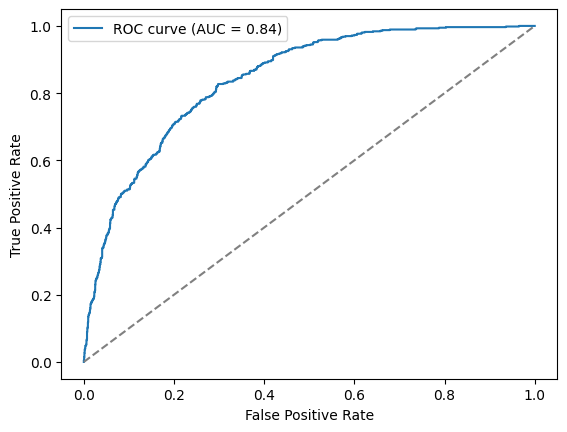

In [52]:
# Analizamos resultados de otro modelo de Balanceo: SMOTETomek
# SMOTETomek = SMOTE-Tomek Links
# ref: https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc/

''' acá tampoco hacemos esto...
# División de datos y escalado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
'''

# Aplicar SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# Entrenar modelo
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_bal, y_train_bal)

# Evaluar en test
y_pred = log_reg.predict(X_test_scaled)
y_proba_smotetomek = log_reg.predict_proba(X_test_scaled)[:, 1]

# Reportes
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba_smotetomek))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_smotetomek)
plt.plot(fpr, tpr, label="ROC curve (AUC = %.2f)" % roc_auc_score(y_test, y_proba_smotetomek))
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## Análisis

Nos damos cuente de que existe 3 modelos de Balanceo, como se había mencionado, también existe la posibilidad de implementar Grid Search (técnica de optimización para obtener mejor combinación de hiperparámetros), esto implica que es necesario implementar un Pipeline (flujo de trabajo estructurado que automatiza y estandariza las distintas etapas de desarrollo e implementación de modelos de IA) que permita automatizar estas distintas etapas, sobre todo considerando que deberemos evaluar varios modelos distintos (LR, RF, KNN, SVM, etc.)

# Entrenando Modelos

## Calentando motores: Probando modelo RandomForest

In [53]:
from sklearn.ensemble import RandomForestClassifier


In [54]:
# Con SMOTE

''' nuevamente nos saltamos esto...
# División y escalado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
'''

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Evaluación
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

# Resultados
print("\n[Random Forest con SMOTE]")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))



[Random Forest con SMOTE]
[[1317  232]
 [ 248  313]]
              precision    recall  f1-score   support

       False       0.84      0.85      0.85      1549
        True       0.57      0.56      0.57       561

    accuracy                           0.77      2110
   macro avg       0.71      0.70      0.71      2110
weighted avg       0.77      0.77      0.77      2110

ROC AUC: 0.8139326274555835


### **Análisis de Random Forest con SMOTE**

#### 📊 Matriz de Confusión

| Tipo                     | Valor | Significado                                                                           |
| ------------------------ | ----- | ------------------------------------------------------------------------------------- |
| **TN** (True Negatives)  | 1321  | Clientes que **no harán churn**, correctamente identificados.                         |
| **FP** (False Positives) | 228   | Clientes que **no harán churn**, pero el modelo predijo que sí. (*falsas alarmas*)    |
| **FN** (False Negatives) | 254   | Clientes que **sí harán churn**, pero el modelo **no los detectó**. (*falla crítica*) |
| **TP** (True Positives)  | 307   | Clientes que **sí harán churn**, correctamente identificados. ✅                       |

---

#### 🔎 Interpretación

| Aspecto              | Valor | Análisis                                                                                                    |
| -------------------- | ----- | ----------------------------------------------------------------------------------------------------------- |
| **Recall**           | 0.547 | 🔻 Bajo: el modelo está **fallando en detectar** más del **45%** de los clientes que realmente harán churn. |
| **Precision**        | 0.574 | Aceptable: cuando predice churn, acierta el \~57% de las veces.                                             |
| **Falsos Negativos** | 254   | ⚠️ Muy alto: significa que **254 clientes que sí cancelarán** no serán detectados a tiempo.                 |
| **Falsos Positivos** | 228   | Moderado: estos son **clientes que serán contactados innecesariamente**.                                    |

#### 🧠 Conclusión

El modelo Random Forest con SMOTE:

- Tiene una alta precisión global (accuracy = 78.5%), pero esto puede ser engañoso dado que el recall es demasiado bajo para un problema de churn.
- El recall de solo 54.7% es inadecuado si tu negocio necesita minimizar la pérdida de clientes reales.
- Es preferible perder algo de precisión o aumentar falsos positivos si a cambio se detectan más churn reales.

#### ✅ Recomendación

Este modelo no es ideal para churn, ya que:

- Detecta menos de la mitad de los clientes en riesgo real.
- Otros modelos como SMOTEENN con mayor recall (~87%) son más apropiados, aunque tengan más falsos positivos.

**IMPORTANTE**: Nuevamente cae la pregunta sin con otros valores para los hiperparámetros podríamos obtener un mejor modelo...


In [55]:
# Ahora intentamos con SMOTEENN

from imblearn.combine import SMOTEENN

# SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_bal, y_train_bal = smote_enn.fit_resample(X_train_scaled, y_train)

# Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Evaluación
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

# Resultados
print("\n[Random Forest con SMOTEENN]")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))



[Random Forest con SMOTEENN]
[[1098  451]
 [ 110  451]]
              precision    recall  f1-score   support

       False       0.91      0.71      0.80      1549
        True       0.50      0.80      0.62       561

    accuracy                           0.73      2110
   macro avg       0.70      0.76      0.71      2110
weighted avg       0.80      0.73      0.75      2110

ROC AUC: 0.8259045856736966


In [56]:
# Y ahora intentamos con SMOTETomek
from imblearn.combine import SMOTETomek

# SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Evaluación
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

# Resultados
print("\n[Random Forest con SMOTETomek]")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


[Random Forest con SMOTETomek]
[[1297  252]
 [ 234  327]]
              precision    recall  f1-score   support

       False       0.85      0.84      0.84      1549
        True       0.56      0.58      0.57       561

    accuracy                           0.77      2110
   macro avg       0.71      0.71      0.71      2110
weighted avg       0.77      0.77      0.77      2110

ROC AUC: 0.8133992490123579


In [57]:
'''
Funcion generica para evaluacion de modelos,
el objetivo es implementar una forma generica y estandar de validacion de todos los modelos que generaremos,
considerando además que usaremos distintos Balanceadores...
Lo destacado de esta función es que recibe como parámetro el modelo instanciado para validarlo.
'''

def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre_modelo="", entrenar=True, imprimir=True):
    """
    Evalúa un modelo en conjuntos de entrenamiento y test, y devuelve métricas clave.

    Args:
        modelo: modelo de sklearn ya instanciado.
        X_train, y_train: datos de entrenamiento (ya balanceados si aplica).
        X_test, y_test: datos de prueba (no balanceados).
        nombre_modelo: string para mostrar en los prints.
        entrenar: si True, se ajusta el modelo con los datos de entrenamiento.
        imprimir: si True, imprime los resultados en consola.

    Returns:
        dict con métricas de entrenamiento y test.
    """

    if entrenar:
        modelo.fit(X_train, y_train)

    # --- Predicciones ---
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    y_train_proba = modelo.predict_proba(X_train)[:, 1]
    y_test_proba = modelo.predict_proba(X_test)[:, 1]

    # --- Métricas ---
    resultados = {
        "modelo": nombre_modelo,

        "train_accuracy": accuracy_score(y_train, y_train_pred),
        "train_precision": precision_score(y_train, y_train_pred),
        "train_recall": recall_score(y_train, y_train_pred),
        "train_f1": f1_score(y_train, y_train_pred),
        "train_auc": roc_auc_score(y_train, y_train_proba),
        "train_confusion": confusion_matrix(y_train, y_train_pred),

        "test_accuracy": accuracy_score(y_test, y_test_pred),
        "test_precision": precision_score(y_test, y_test_pred),
        "test_recall": recall_score(y_test, y_test_pred),
        "test_f1": f1_score(y_test, y_test_pred),
        "test_auc": roc_auc_score(y_test, y_test_proba),
        "test_confusion": confusion_matrix(y_test, y_test_pred),
    }

    if imprimir:
        print(f"\n🔍 Modelo: {nombre_modelo}")
        print("\n--- ENTRENAMIENTO ---")
        print("Confusion Matrix:\n", resultados["train_confusion"])
        print(f"Accuracy: {resultados['train_accuracy']:.4f}")
        print(f"Precision: {resultados['train_precision']:.4f}")
        print(f"Recall: {resultados['train_recall']:.4f}")
        print(f"F1-score: {resultados['train_f1']:.4f}")
        print(f"ROC AUC: {resultados['train_auc']:.4f}")

        print("\n--- TEST ---")
        print("Confusion Matrix:\n", resultados["test_confusion"])
        print(f"Accuracy: {resultados['test_accuracy']:.4f}")
        print(f"Precision: {resultados['test_precision']:.4f}")
        print(f"Recall: {resultados['test_recall']:.4f}")
        print(f"F1-score: {resultados['test_f1']:.4f}")
        print(f"ROC AUC: {resultados['test_auc']:.4f}")

    return resultados

In [58]:
# Probamos la función implementada, con RandomForest + SMOTETomek

# Preparar los datos
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# Crear y evaluar modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)
resultados_rf_tomek = evaluar_modelo(rf, X_train_bal, y_train_bal, X_test_scaled, y_test, nombre_modelo="RF + SMOTETomek")
resultados_rf_tomek



🔍 Modelo: RF + SMOTETomek

--- ENTRENAMIENTO ---
Confusion Matrix:
 [[3429    5]
 [   2 3432]]
Accuracy: 0.9990
Precision: 0.9985
Recall: 0.9994
F1-score: 0.9990
ROC AUC: 1.0000

--- TEST ---
Confusion Matrix:
 [[1297  252]
 [ 234  327]]
Accuracy: 0.7697
Precision: 0.5648
Recall: 0.5829
F1-score: 0.5737
ROC AUC: 0.8134


{'modelo': 'RF + SMOTETomek',
 'train_accuracy': 0.9989807804309843,
 'train_precision': 0.9985452429444283,
 'train_recall': 0.9994175888177053,
 'train_f1': 0.9989812254402561,
 'train_auc': np.float64(0.9999885095056492),
 'train_confusion': array([[3429,    5],
        [   2, 3432]]),
 'test_accuracy': 0.7696682464454976,
 'test_precision': 0.5647668393782384,
 'test_recall': 0.5828877005347594,
 'test_f1': 0.5736842105263158,
 'test_auc': np.float64(0.8133992490123579),
 'test_confusion': array([[1297,  252],
        [ 234,  327]])}

## Primer acercamiento a Grid Search

Primeras pruebas...

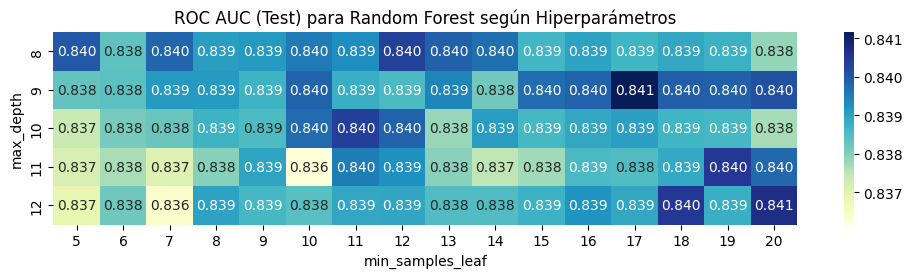

In [59]:
'''
Generar todas las combinaciones de hiperparámetros,
se genera un heatmap para identificar la mejor combinación,
por ahora, simplemente graficamos ROC AUC de test,
luego se deberá definir qué métrica usar para el ranking...
'''

# generamos el rango óptimo para algunos hiperparámetros de RandomForest
depth_range = range(8, 13)  # 8 to 12 inclusive
leaf_range = range(5, 21)   # 5 to 20 inclusive

# los combinamos, para iterarlos...
combinaciones = list(product(depth_range, leaf_range))

# Entrenar y evaluar cada combinación
resultados_grid = []
for max_depth, min_samples_leaf in combinaciones:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    resultados = evaluar_modelo(
        rf,
        X_train_bal, y_train_bal,
        X_test_scaled, y_test,
        nombre_modelo=f"RF_depth{max_depth}_leaf{min_samples_leaf}",
        entrenar=True,
        imprimir=False  # evitamos imprimir en cada iteración
    )

    resultados["max_depth"] = max_depth
    resultados["min_samples_leaf"] = min_samples_leaf
    resultados_grid.append(resultados)

# Convertir a DataFrame para análisis

df_resultados = pd.DataFrame(resultados_grid)

# Visualizar los resultados con un heatmap

pivot_auc = df_resultados.pivot(index="max_depth", columns="min_samples_leaf", values="test_auc")

# Generamos un Heatmap para identificación visual de la mejor combinación de hiperparámetros
# por ahora evaluamos ROC AUC
height = 0.5 * len(pivot_auc)
plt.figure(figsize=(12, height))
sns.heatmap(pivot_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("ROC AUC (Test) para Random Forest según Hiperparámetros")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.show()




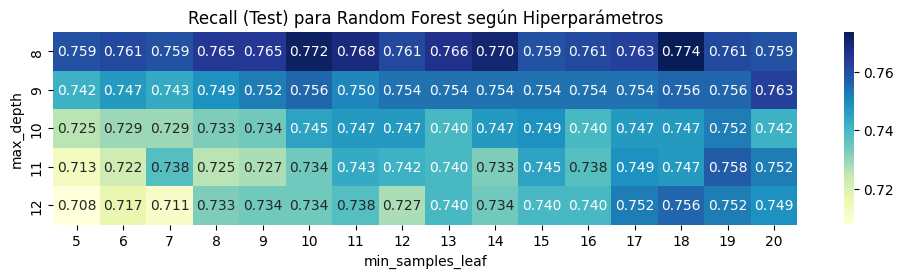

In [60]:
# Generamos un Heatmap para identificación visual de la mejor combinación de hiperparámetros
# ahora evaluamos métrica Recall (Test)

pivot_recall = df_resultados.pivot(index="max_depth", columns="min_samples_leaf", values="test_recall")

height = 0.5 * len(pivot_recall)  # 0.5 pulgadas por fila
plt.figure(figsize=(12, height))

sns.heatmap(pivot_recall, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Recall (Test) para Random Forest según Hiperparámetros")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.show()

In [61]:
df_resultados

,modelo,train_accuracy,train_precision,train_recall,train_f1,train_auc,train_confusion,test_accuracy,test_precision,test_recall,test_f1,test_auc,test_confusion,max_depth,min_samples_leaf
0,RF_depth8_leaf5,0.864153,0.838064,0.902737,0.869199,0.933583,"[[2835, 599], [334, 3100]]",0.763507,0.539241,0.759358,0.630644,0.839999,"[[1185, 364], [135, 426]]",8,5
1,RF_depth8_leaf6,0.860949,0.838015,0.894875,0.865512,0.932663,"[[2840, 594], [361, 3073]]",0.767299,0.544643,0.761141,0.634944,0.838354,"[[1192, 357], [134, 427]]",8,6
2,RF_depth8_leaf7,0.857455,0.835474,0.890215,0.861977,0.930495,"[[2832, 602], [377, 3057]]",0.766351,0.543367,0.759358,0.633457,0.839808,"[[1191, 358], [135, 426]]",8,7
3,RF_depth8_leaf8,0.855999,0.835023,0.887303,0.860370,0.929232,"[[2832, 602], [387, 3047]]",0.767299,0.544416,0.764706,0.636027,0.839069,"[[1190, 359], [132, 429]]",8,8
4,RF_depth8_leaf9,0.855125,0.832924,0.888468,0.859800,0.928748,"[[2822, 612], [383, 3051]]",0.763507,0.538945,0.764706,0.632277,0.839133,"[[1182, 367], [132, 429]]",8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,RF_depth12_leaf16,0.853815,0.840336,0.873617,0.856653,0.930772,"[[2864, 570], [434, 3000]]",0.766825,0.545335,0.739750,0.627837,0.839229,"[[1203, 346], [146, 415]]",12,16
76,RF_depth12_leaf17,0.852650,0.839216,0.872452,0.855511,0.929401,"[[2860, 574], [438, 2996]]",0.770616,0.550196,0.752228,0.635542,0.838902,"[[1204, 345], [139, 422]]",12,17
77,RF_depth12_leaf18,0.851340,0.837861,0.871287,0.854247,0.927952,"[[2855, 579], [442, 2992]]",0.768720,0.547097,0.755793,0.634731,0.840481,"[[1198, 351], [137, 424]]",12,18
78,RF_depth12_leaf19,0.848573,0.835294,0.868375,0.851513,0.926762,"[[2846, 588], [452, 2982]]",0.767299,0.545220,0.752228,0.632210,0.838798,"[[1197, 352], [139, 422]]",12,19


## Grid Search con RandomForest

In [62]:
'''
Se genera una función que recibe los dataset balanceados
usada por la funcion mas abajo buscar_mejor_modelo_con_balanceo_RF()

El objetivo de esta función es que realice un Grid Search para modelos RandomForest
'''

def buscar_mejor_modelo_rf_auto(X_train_bal, y_train_bal, X_test_scaled, y_test,
                                max_depth_range=range(8, 13),
                                min_samples_leaf_range=range(5, 21),
                                n_estimators_list=[100, 150, 200],
                                mostrar_heatmap=True):
    """
    Busca el mejor modelo RandomForest según múltiples métricas, sin intervención del usuario.

    Devuelve:
        - df_resultados: DataFrame con todas las métricas y rankings
        - mejor_resultado: dict con hiperparámetros y métricas del mejor modelo
    """

    combinaciones = list(product(max_depth_range, min_samples_leaf_range, n_estimators_list))
    resultados = []

    for max_depth, min_samples_leaf, n_estimators in combinaciones:
        modelo = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

        resultado = evaluar_modelo(
            modelo,
            X_train_bal, y_train_bal,
            X_test_scaled, y_test,
            nombre_modelo=f"RF_depth{max_depth}_leaf{min_samples_leaf}",
            entrenar=True,
            imprimir=False
        )

        resultado["max_depth"] = max_depth
        resultado["min_samples_leaf"] = min_samples_leaf
        resultado["n_estimators"] = n_estimators
        resultados.append(resultado)

    return pd.DataFrame(resultados)



In [63]:
# esto tarda un poco...
df_rf_auto = buscar_mejor_modelo_rf_auto(
    X_train_bal, y_train_bal, X_test_scaled, y_test
)

In [64]:
df_rf_auto

,modelo,train_accuracy,train_precision,train_recall,train_f1,train_auc,train_confusion,test_accuracy,test_precision,test_recall,test_f1,test_auc,test_confusion,max_depth,min_samples_leaf,n_estimators
0,RF_depth8_leaf5,0.864153,0.838064,0.902737,0.869199,0.933583,"[[2835, 599], [334, 3100]]",0.763507,0.539241,0.759358,0.630644,0.839999,"[[1185, 364], [135, 426]]",8,5,100
1,RF_depth8_leaf5,0.864589,0.839112,0.902155,0.869492,0.933411,"[[2840, 594], [336, 3098]]",0.764929,0.541401,0.757576,0.631501,0.840089,"[[1189, 360], [136, 425]]",8,5,150
2,RF_depth8_leaf5,0.862260,0.837493,0.898952,0.867135,0.933707,"[[2835, 599], [347, 3087]]",0.764929,0.541401,0.757576,0.631501,0.839769,"[[1189, 360], [136, 425]]",8,5,200
3,RF_depth8_leaf6,0.860949,0.838015,0.894875,0.865512,0.932663,"[[2840, 594], [361, 3073]]",0.767299,0.544643,0.761141,0.634944,0.838354,"[[1192, 357], [134, 427]]",8,6,100
4,RF_depth8_leaf6,0.862260,0.838227,0.897787,0.866985,0.932063,"[[2839, 595], [351, 3083]]",0.763033,0.538953,0.752228,0.627976,0.839327,"[[1188, 361], [139, 422]]",8,6,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,RF_depth12_leaf19,0.849884,0.836649,0.869540,0.852777,0.926854,"[[2851, 583], [448, 2986]]",0.766825,0.544631,0.750446,0.631184,0.839752,"[[1197, 352], [140, 421]]",12,19,150
236,RF_depth12_leaf19,0.849156,0.836231,0.868375,0.852000,0.926958,"[[2850, 584], [452, 2982]]",0.766351,0.544156,0.746881,0.629602,0.839592,"[[1198, 351], [142, 419]]",12,19,200
237,RF_depth12_leaf20,0.848136,0.834968,0.867793,0.851064,0.925619,"[[2845, 589], [454, 2980]]",0.766825,0.544747,0.748663,0.630631,0.840672,"[[1198, 351], [141, 420]]",12,20,100
238,RF_depth12_leaf20,0.848427,0.836379,0.866337,0.851094,0.925850,"[[2852, 582], [459, 2975]]",0.764455,0.541451,0.745098,0.627157,0.840935,"[[1195, 354], [143, 418]]",12,20,150


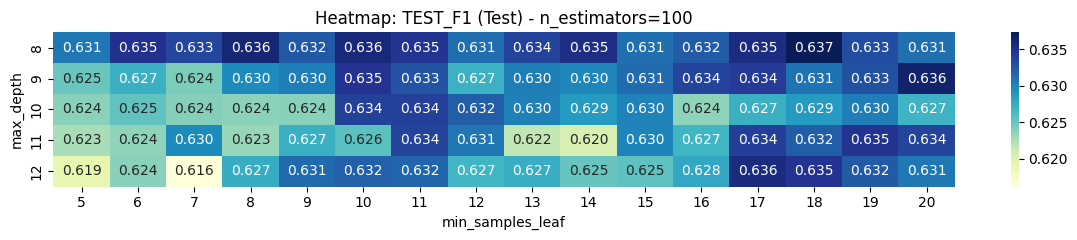


✅ Mejor modelo (según ranking combinado de métricas):
  - max_depth: 10
  - min_samples_leaf: 11
  - Ranking Promedio: 0.8459
  - test_auc: 0.8405
  - test_f1: 0.6365
  - test_recall: 0.7522
  - test_precision: 0.5516
  - test_accuracy: 0.7716


In [65]:

df = df_rf_auto

# --- Normalizar las métricas que queremos considerar ---
metricas_clave = ["test_auc", "test_f1", "test_recall", "test_precision", "test_accuracy"]
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[metricas_clave]), columns=metricas_clave)

# --- Calcular ranking promedio ---
df["ranking_promedio"] = df_norm.mean(axis=1)

# --- Identificar mejor modelo ---
mejor_idx = df["ranking_promedio"].idxmax()
mejor_modelo = df.loc[mejor_idx].to_dict()

# --- Visualización: heatmap de la métrica dominante ---
metrica_dominante = df_norm.mean().idxmax()
#pivot = df.pivot(index="max_depth", columns="min_samples_leaf", values=metrica_dominante)

# Filtrar por un valor específico de n_estimator
n_estimator_para_visualizar = 100
df_filtrado = df[df["n_estimators"] == n_estimator_para_visualizar]

pivot = df_filtrado.pivot(index="max_depth", columns="min_samples_leaf", values=metrica_dominante)

height = 0.5 * len(pivot)
plt.figure(figsize=(12, height))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title(f"Heatmap: {metrica_dominante.upper()} (Test) - n_estimators={n_estimator_para_visualizar}")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

# --- Reporte final ---
print(f"\n✅ Mejor modelo (según ranking combinado de métricas):")
print(f"  - max_depth: {mejor_modelo['max_depth']}")
print(f"  - min_samples_leaf: {mejor_modelo['min_samples_leaf']}")
print(f"  - Ranking Promedio: {mejor_modelo['ranking_promedio']:.4f}")
for m in metricas_clave:
    print(f"  - {m}: {mejor_modelo[m]:.4f}")

#return df, mejor_modelo

In [66]:
mejor_modelo

{'modelo': 'RF_depth10_leaf11',
 'train_accuracy': 0.8645894001164822,
 'train_precision': 0.8475846751804553,
 'train_recall': 0.8890506697728596,
 'train_f1': 0.8678226264923252,
 'train_auc': 0.9371536103557254,
 'train_confusion': array([[2885,  549],
        [ 381, 3053]]),
 'test_accuracy': 0.771563981042654,
 'test_precision': 0.5516339869281046,
 'test_recall': 0.7522281639928698,
 'test_f1': 0.6365007541478129,
 'test_auc': 0.8404680611607281,
 'test_confusion': array([[1206,  343],
        [ 139,  422]]),
 'max_depth': 10,
 'min_samples_leaf': 11,
 'n_estimators': 150,
 'ranking_promedio': 0.8459287358860621}

### Conclusión

Hasta el momento se ha implementado funciones que permiten automatizar el proceso de encontrar el mejor modelo de RandomForest, incluyendo la validación de distintos Balanceadores y aplicando técnica Grid Search, pero por ahora no hemos definido totalmente qué métrica se debiese usar para encontrar, para nuestro caso específico de Churn, el modelo óptimo.
Lo anterior es relevante para evitar interpretaciones ambiguas como:

- "El modelo A tiene mejor Recall pero peor Precision"

- "El AUC es más alto, pero el F1 es más bajo"


## Evaluación y búsqueda del mejor modelo

Luego de algunas iteraciones con ayuda de Chat GPT, se logra establecer una función que pudiese ser una buena opción para encontrar el mejor Modelo que resuelva el objetivo planteado: desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

El **Índice Compuesto de Métricas (ICM)** ponderado se define como:

\[
\text{ICM}_{\alpha, w} = \frac{w_r \cdot \text{Recall} + w_f \cdot \text{F1} + w_a \cdot \text{AUC}}{1 + \alpha \cdot \text{FPR}}
\]

Donde:

- \( w_r \): peso asignado al **Recall**  
- \( w_f \): peso asignado al **F1-score**  
- \( w_a \): peso asignado al **AUC**  
- \( \alpha \): parámetro que controla la penalización por **falsos positivos**  
- \( \text{FPR} \): False Positive Rate


> **Nota:** Esta fórmula permite ajustar la importancia relativa de cada métrica según el problema.  

Dado que para tareas de *Churn Prediction*, se recomienda priorizar **Recall** sobre el resto, estos son los pesos sugeridos a utilizar:

| Métrica | Peso sugerido |
| ------- | ------------- |
| Recall  | 0.6           |
| F1      | 0.3           |
| AUC     | 0.1           |




In [67]:
'''
Se implementa una función para cálculo del ICM, con parámetros de los pesos y con valores predefinidos,
la idea de los valores de estos parámetros es darle más importancia al Recall
'''

def calcular_icm(df, alpha=1, w_recall=0.5, w_f1=0.3, w_auc=0.2):
    """
    Calcula el Índice Compuesto de Modelo (ICM) ponderado y penalizado por FPR.

    Fórmula:
        ICM = (w_recall * Recall + w_f1 * F1 + w_auc * AUC) / (1 + alpha * FPR)

    Parámetros:
        df : pd.DataFrame - debe contener las columnas: recall, f1, auc, fpr
        alpha : float - penalización por FPR
        w_recall, w_f1, w_auc : float - pesos para recall, f1, auc respectivamente (suma debe ser 1)

    Retorna:
        pd.Series con el valor del ICM para cada fila.
    """

    # Validación opcional: asegurar que los pesos sumen 1 (puedes quitar esta línea si no lo deseas)
    if not np.isclose(w_recall + w_f1 + w_auc, 1.0):
        raise ValueError("La suma de los pesos (w_recall + w_f1 + w_auc) debe ser 1.")

    numerador = (
        w_recall * df['recall'] +
        w_f1 * df['f1'] +
        w_auc * df['auc']
    )
    denominador = 1 + alpha * df['fpr']

    icm = numerador / denominador
    return icm


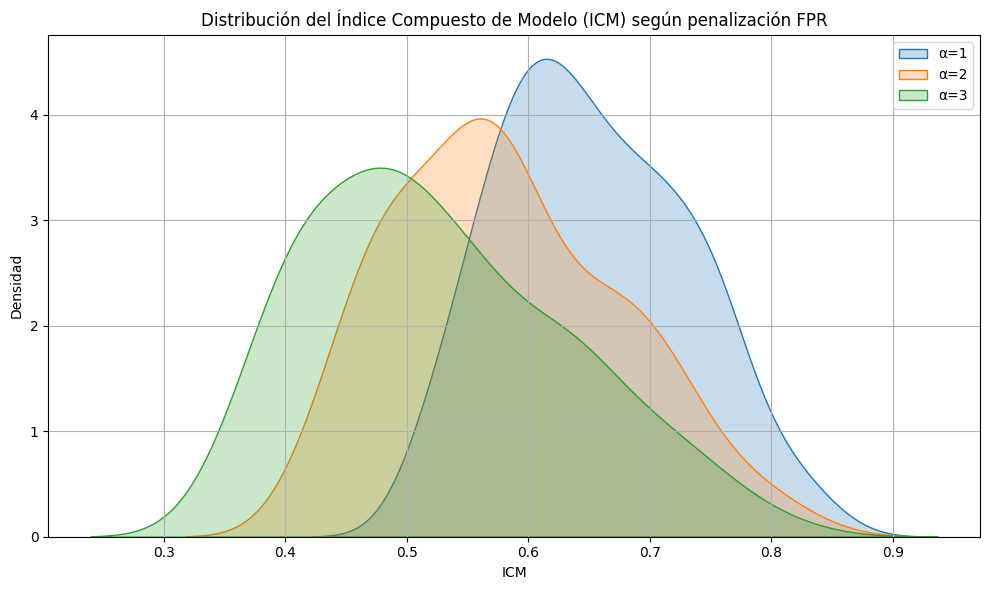

       ICM_alpha_1  ICM_alpha_2  ICM_alpha_3
count   150.000000   150.000000   150.000000
mean      0.653492     0.581772     0.526825
std       0.077839     0.094035     0.106915
min       0.508753     0.421468     0.357432
25%       0.595319     0.512383     0.444632
50%       0.646457     0.570601     0.509841
75%       0.713138     0.652221     0.608902
max       0.847652     0.833204     0.819240


In [68]:
# Probamos el ICM
# se simulan combinaciones de métricas realistas para modelos de churn

np.random.seed(42)

def generar_casos_prueba(n=100):
    """Genera n casos de prueba simulados con métricas realistas."""
    casos = []
    for _ in range(n):
        recall = np.random.uniform(0.6, 0.95)          # Alta prioridad en churn
        precision = np.random.uniform(0.4, 0.8)
        f1 = 2 * (precision * recall) / (precision + recall)
        auc = np.random.uniform(0.75, 0.9)
        fpr = np.random.uniform(0.01, 0.3)             # Falsos positivos aceptables a controlados
        casos.append({
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'auc': auc,
            'fpr': fpr
        })
    return pd.DataFrame(casos)

# Generar casos
casos = generar_casos_prueba(150)

# Calcular ICM para diferentes penalizaciones de falsos positivos
casos['ICM_alpha_1'] = calcular_icm(casos, alpha=1)
casos['ICM_alpha_2'] = calcular_icm(casos, alpha=2)
casos['ICM_alpha_3'] = calcular_icm(casos, alpha=3)

# Visualizar las distribuciones
plt.figure(figsize=(10, 6))
sns.kdeplot(casos['ICM_alpha_1'], label='α=1', fill=True)
sns.kdeplot(casos['ICM_alpha_2'], label='α=2', fill=True)
sns.kdeplot(casos['ICM_alpha_3'], label='α=3', fill=True)
plt.title("Distribución del Índice Compuesto de Modelo (ICM) según penalización FPR")
plt.xlabel("ICM")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar resumen estadístico
resumen = casos[['ICM_alpha_1', 'ICM_alpha_2', 'ICM_alpha_3']].describe()
print(resumen)


In [69]:
# Continuacion del anterior...

# Métricas de ejemplo obtenidas de tus modelos anteriores
modelos_metricas = [
    {"modelo": "SMOTE", "recall": 0.782, "precision": 0.505, "f1": 0.615, "auc": 0.836, "fpr": 430 / (430 + 1119)},
    {"modelo": "SMOTEENN", "recall": 0.872, "precision": 0.454, "f1": 0.596, "auc": 0.850, "fpr": 588 / (588 + 961)},
    {"modelo": "SMOTETomek", "recall": 0.788, "precision": 0.507, "f1": 0.617, "auc": 0.840, "fpr": 429 / (429 + 1120)},
    {"modelo": "RF + SMOTE", "recall": 0.547, "precision": 0.574, "f1": 0.560, "auc": 0.830, "fpr": 228 / (228 + 1321)},
    {"modelo": "RF + SMOTEENN", "recall": 0.799, "precision": 0.493, "f1": 0.610, "auc": 0.843, "fpr": 460 / (460 + 1089)},
    {"modelo": "RF + SMOTETomek", "recall": 0.560, "precision": 0.556, "f1": 0.558, "auc": 0.828, "fpr": 250 / (250 + 1299)},
]

# Crear DataFrame
df_modelos = pd.DataFrame(modelos_metricas)

# Calcular ICM con diferentes niveles de penalización por FPR (alpha)
for alpha in [1, 2, 3]:
    df_modelos[f"ICM_alpha_{alpha}"] = (
        (df_modelos["recall"] + df_modelos["precision"] + df_modelos["f1"] + df_modelos["auc"]) *
        ((1 - df_modelos["fpr"]) ** alpha)
    )

# Ordenar por ICM con alpha = 2
df_modelos_sorted = df_modelos.sort_values(by="ICM_alpha_2", ascending=False)

# Mostrar resultados clave
print(df_modelos_sorted[["modelo", "ICM_alpha_1", "ICM_alpha_2", "ICM_alpha_3"]])

            modelo  ICM_alpha_1  ICM_alpha_2  ICM_alpha_3
3       RF + SMOTE     2.141402     1.826205     1.557403
5  RF + SMOTETomek     2.098191     1.759555     1.475572
2       SMOTETomek     1.989826     1.438738     1.040275
0            SMOTE     1.977935     1.428864     1.032213
4    RF + SMOTEENN     1.929829     1.356736     0.953832
1         SMOTEENN     1.719750     1.066933     0.661926


# 🔍 ¿Cómo se evalúan overfitting y underfitting?

La lógica sigue siendo:

✅ Overfitting:

Altísima precisión en entrenamiento
Mucho peor rendimiento en test
Ejemplo: train_f1 = 0.95, test_f1 = 0.60 → Gran diferencia

✅ Underfitting:

Bajo rendimiento tanto en train como en test
Modelo no está capturando el patrón
Ejemplo: train_f1 = 0.60, test_f1 = 0.58

In [70]:
def detectar_overfitting_underfitting(metricas_train, metricas_test):
    """
    Compara métricas de entrenamiento y test para detectar overfitting o underfitting.
    Devuelve diagnóstico, diferencias absolutas y con signo, y explicación.
    """

    diferencias_metricas = {}
    diferencias_metricas_signed = {}

    for metrica in ["f1", "recall", "auc"]:
        train = metricas_train.get(metrica)
        test = metricas_test.get(metrica)
        if train is None or test is None:
            continue
        diferencia_signed = train - test
        diferencias_metricas[metrica] = abs(diferencia_signed)
        diferencias_metricas_signed[metrica] = diferencia_signed

    # Umbral para alerta (puedes ajustar)
    umbral_leve = 0.05
    umbral_grave = 0.15

    # Diagnóstico automático basado en la diferencia promedio
    dif_prom = sum(diferencias_metricas_signed.values()) / len(diferencias_metricas_signed)

    if dif_prom > umbral_grave:
        diagnostico = "overfitting"
    elif dif_prom < -umbral_grave:
        diagnostico = "underfitting"
    else:
        diagnostico = "sin indicios claros"

    # Explicación textual
    explicacion = ""
    if diagnostico == "overfitting":
        explicacion = (
            f"El modelo tiene buen desempeño en entrenamiento "
            f"(e.g. f1={metricas_train['f1']:.2f}) pero bajo rendimiento en test "
            f"(f1={metricas_test['f1']:.2f}). "
            f"Indicios de **overfitting**: el modelo podría estar memorizando los datos de entrenamiento."
        )
    elif diagnostico == "underfitting":
        explicacion = (
            f"El modelo tiene peor rendimiento en entrenamiento "
            f"(f1={metricas_train['f1']:.2f}) que en test (f1={metricas_test['f1']:.2f}), "
            f"lo que puede indicar **underfitting**: el modelo no está capturando patrones suficientes."
        )
    else:
        explicacion = (
            "No se detectan diferencias graves entre entrenamiento y test. "
            "No hay indicios fuertes de overfitting ni underfitting."
        )

    return {
        "diagnostico": diagnostico,
        "diferencias_metricas": diferencias_metricas,
        "diferencias_metricas_signed": diferencias_metricas_signed,
        "explicacion": explicacion
    }



# Implementación, Evaluación y Obtención del mejor modelo

## Implementación de funciones de apoyo

In [71]:
# ======================================================
# 1. Nueva función: generar datasets balanceados
# ======================================================
def generar_datasets_balanceados(X_train, y_train, X_test, escalar=False):
    """
    Genera datasets balanceados (SMOTE, SMOTEENN, SMOTETomek).
    Si escalar=True, aplica StandardScaler.
    """
    balanceadores = {
        "SMOTE": SMOTE(random_state=42),
        "SMOTEENN": SMOTEENN(random_state=42),
        "SMOTETomek": SMOTETomek(random_state=42)
    }

    if escalar:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    datasets = {}
    for nombre, balancer in balanceadores.items():
        X_train_bal, y_train_bal = balancer.fit_resample(X_train, y_train)
        datasets[nombre] = (X_train_bal, y_train_bal, X_test)

    return datasets



In [72]:
# ======================================================
# 2. Fórmula ICM
# ======================================================
def calcular_icm(metricas, alpha=1, w_recall=0.5, w_f1=0.3, w_auc=0.2):
    """
    Calcula el Índice Compuesto de Modelo (ICM) ponderado y penalizado por FPR.

    Fórmula:
        ICM = (w_recall * Recall + w_f1 * F1 + w_auc * AUC) / (1 + alpha * FPR)

    Parámetros:
        df : pd.DataFrame - debe contener las columnas: recall, f1, auc, fpr
        alpha : float - penalización por FPR
        w_recall, w_f1, w_auc : float - pesos para recall, f1, auc respectivamente (suma debe ser 1)

    Retorna:
        pd.Series con el valor del ICM para cada fila.
    """

    # Validación opcional: asegurar que los pesos sumen 1 (puedes quitar esta línea si no lo deseas)
    if not np.isclose(w_recall + w_f1 + w_auc, 1.0):
        raise ValueError("La suma de los pesos (w_recall + w_f1 + w_auc) debe ser 1.")

    # confusion_matrix: para obtener FPR
    tn, fp, fn, tp = confusion_matrix(metricas['y_true'], metricas['y_pred']).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

    numerador = (
        w_recall * metricas['test_recall'] +
        w_f1 * metricas['test_f1'] +
        w_auc * metricas['test_auc']
    )
    denominador = 1 + alpha * fpr

    icm = numerador / denominador
    return icm



In [73]:
# ======================================================
# 3. Evaluación de modelo (ajustada para ICM)
# ======================================================
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test):
    """
    Evalúa modelo entrenado en train y test y retorna métricas + diagnostico.
    """
    # --- Train ---
    y_train_pred = modelo.predict(X_train)
    if hasattr(modelo, "predict_proba"):
        y_train_proba = modelo.predict_proba(X_train)[:, 1]
    else:  # Para SVM con probability=True
        y_train_proba = modelo.decision_function(X_train)
        y_train_proba = (y_train_proba - y_train_proba.min()) / (y_train_proba.max() - y_train_proba.min())

    # --- Test ---
    y_test_pred = modelo.predict(X_test)
    if hasattr(modelo, "predict_proba"):
        y_test_proba = modelo.predict_proba(X_test)[:, 1]
    else:
        y_test_proba = modelo.decision_function(X_test)
        y_test_proba = (y_test_proba - y_test_proba.min()) / (y_test_proba.max() - y_test_proba.min())

    # Métricas
    metricas_train = {
        'f1': f1_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'auc': roc_auc_score(y_train, y_train_proba),
        'precision': precision_score(y_train, y_train_pred),
        'accuracy': accuracy_score(y_train, y_train_pred)
    }
    metricas_test = {
        'test_f1': f1_score(y_test, y_test_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'test_precision': precision_score(y_test, y_test_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'y_true': y_test,
        'y_pred': y_test_pred
    }

    # Diagnóstico
    metricas_test_simple = {
        'f1': metricas_test['test_f1'],
        'recall': metricas_test['test_recall'],
        'auc': metricas_test['test_auc']
    }
    diagnostico = detectar_overfitting_underfitting(metricas_train, metricas_test_simple)

    return metricas_train, metricas_test, diagnostico


## Implementación funciones para búsqueda del modelo óptimo

Se implementa una función "principal" por cada modelo (LinearRegression, RandomForest, SVM, KNN, etc.), cada una devolverá su mejor modelo usando Grid Search e ICM.
Finalmente, se implementa una función que evaluará estos "mejores modelos" y nuevamente usando ICM, entregará su veredicto final del mejor modelo.


In [74]:
# ======================================================
# 1. Logistic Regression
# ======================================================
def buscar_mejor_modelo_LogisticRegression(datasets, y_test):
    param_grid = [
        {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'},
        {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'},
        {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'},
        {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'},
    ]

    mejores_resultados = []

    for params in param_grid:
        for nombre_balanceo, (X_train_bal, y_train_bal, X_test_proc) in datasets.items():
            modelo = LogisticRegression(**params)
            modelo.fit(X_train_bal, y_train_bal)

            metricas_train, metricas_test, diagnostico = evaluar_modelo(
                modelo, X_train_bal, y_train_bal, X_test_proc, y_test
            )

            icm_scores = {a: calcular_icm(metricas_test, alpha=a) for a in [1, 2, 3]}

            mejores_resultados.append({
                'modelo': modelo,
                'model_name': "LogisticRegression",
                'balanceo': nombre_balanceo,
                'hiperparametros': params,
                'metricas': metricas_test,
                'metricas_train': metricas_train,
                'diagnostico': diagnostico,
                'ICM': icm_scores
            })

    mejor_modelo = max(mejores_resultados, key=lambda r: r['ICM'][1])
    return {'model': 'LogisticRegression', 'resultado': mejor_modelo}



In [75]:
# ======================================================
# 2. Random Forest
# ======================================================
def buscar_mejor_modelo_RF(datasets, y_test, random_state=42):
    max_depths = [8, 10, 12]
    min_samples_leafs = [5, 10, 15]

    mejores_resultados = []

    for nombre_balanceo, (X_train_bal, y_train_bal, X_test_proc) in datasets.items():
        for max_depth in max_depths:
            for min_samples_leaf in min_samples_leafs:
                modelo = RandomForestClassifier(
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    random_state=random_state,
                    n_jobs=-1
                )
                modelo.fit(X_train_bal, y_train_bal)

                metricas_train, metricas_test, diagnostico = evaluar_modelo(
                    modelo, X_train_bal, y_train_bal, X_test_proc, y_test
                )

                icm_scores = {a: calcular_icm(metricas_test, alpha=a) for a in [1, 2, 3]}

                mejores_resultados.append({
                    'modelo': modelo,
                    'model_name': "RandomForest",
                    'balanceo': nombre_balanceo,
                    'hiperparametros': {"max_depth": max_depth, "min_samples_leaf": min_samples_leaf},
                    'metricas': metricas_test,
                    'metricas_train': metricas_train,
                    'diagnostico': diagnostico,
                    'ICM': icm_scores
                })

    mejor_modelo = max(mejores_resultados, key=lambda r: r['ICM'][1])
    return {'model': 'RandomForest', 'resultado': mejor_modelo}

In [92]:
# ======================================================
# 3. SVM - Support Vector Machine
# ======================================================
def buscar_mejor_modelo_SVM(datasets, y_test, random_state=42):
    """
    Usa datasets YA balanceados (y escalados!) en formato:
      datasets = { 'SMOTE': (X_train_bal, y_train_bal, X_test_proc), ... }
    """
    # Grid de hiperparámetros (probability=True para AUC estable)
    param_grid = [
        {'C': 0.1, 'kernel': 'linear', 'probability': True},
        {'C': 1.0, 'kernel': 'linear', 'probability': True},
        {'C': 1.0, 'kernel': 'rbf',   'gamma': 'scale', 'probability': True},
        {'C': 10.0,'kernel': 'rbf',   'gamma': 'scale', 'probability': True},
    ]

    mejores_resultados = []

    for nombre_balanceo, (X_train_bal, y_train_bal, X_test_proc) in datasets.items():
        for params in param_grid:
            modelo = SVC(random_state=random_state, **params)
            modelo.fit(X_train_bal, y_train_bal)

            metricas_train, metricas_test, diagnostico = evaluar_modelo(
                modelo, X_train_bal, y_train_bal, X_test_proc, y_test
            )

            icm_scores = {a: calcular_icm(metricas_test, alpha=a) for a in [1, 2, 3]}

            mejores_resultados.append({
                'modelo': modelo,
                'model_name': 'SVC',
                'balanceo': nombre_balanceo,
                'hiperparametros': params,
                'metricas': metricas_test,
                'metricas_train': metricas_train,
                'diagnostico': diagnostico,
                'ICM': icm_scores
            })

    mejor_modelo = max(mejores_resultados, key=lambda r: r['ICM'][1])  # α=1 por defecto
    return {'model': 'SVM', 'resultado': mejor_modelo}




In [93]:
# ======================================================
# 4. XGBoost
# ======================================================
def buscar_mejor_modelo_XGBoost(datasets, y_test, random_state=42):
    """
    Usa datasets YA balanceados (NO escalados) en formato:
      datasets = { 'SMOTE': (X_train_bal, y_train_bal, X_test_proc), ... }
    """
    param_grid = [
        {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1,  'subsample': 1.0, 'colsample_bytree': 1.0},
        {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8},
        {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.8},
    ]

    mejores_resultados = []

    for nombre_balanceo, (X_train_bal, y_train_bal, X_test_proc) in datasets.items():
        for params in param_grid:
            modelo = XGBClassifier(
                random_state=random_state,
                n_jobs=-1,
                eval_metric='logloss',
                use_label_encoder=False,
                **params
            )
            modelo.fit(X_train_bal, y_train_bal)

            metricas_train, metricas_test, diagnostico = evaluar_modelo(
                modelo, X_train_bal, y_train_bal, X_test_proc, y_test
            )

            icm_scores = {a: calcular_icm(metricas_test, alpha=a) for a in [1, 2, 3]}

            mejores_resultados.append({
                'modelo': modelo,
                'model_name': 'XGBClassifier',
                'balanceo': nombre_balanceo,
                'hiperparametros': params,
                'metricas': metricas_test,
                'metricas_train': metricas_train,
                'diagnostico': diagnostico,
                'ICM': icm_scores
            })

    mejor_modelo = max(mejores_resultados, key=lambda r: r['ICM'][1])  # α=1 por defecto
    return {'model': 'XGBoost', 'resultado': mejor_modelo}



In [99]:
# ======================================================
# 5. DecisionTree
# ======================================================
def buscar_mejor_modelo_DT(datasets, y_test, random_state=42):
    """
    Usa datasets YA balanceados (NO escalados).
    """
    max_depths = [5, 8, 10, 12]
    min_samples_leafs = [5, 10, 15]

    mejores_resultados = []

    for nombre_balanceo, (X_train_bal, y_train_bal, X_test_proc) in datasets.items():
        for max_depth in max_depths:
            for min_samples_leaf in min_samples_leafs:
                modelo = DecisionTreeClassifier(
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    random_state=random_state
                )
                modelo.fit(X_train_bal, y_train_bal)

                metricas_train, metricas_test, diagnostico = evaluar_modelo(
                    modelo, X_train_bal, y_train_bal, X_test_proc, y_test
                )

                icm_scores = {a: calcular_icm(metricas_test, alpha=a) for a in [1, 2, 3]}

                mejores_resultados.append({
                    'modelo': modelo,
                    'model_name': 'DecisionTree',
                    'balanceo': nombre_balanceo,
                    'hiperparametros': {"max_depth": max_depth, "min_samples_leaf": min_samples_leaf},
                    'metricas': metricas_test,
                    'metricas_train': metricas_train,
                    'diagnostico': diagnostico,
                    'ICM': icm_scores
                })

    mejor_modelo = max(mejores_resultados, key=lambda r: r['ICM'][1])
    return {'model': 'DecisionTree', 'resultado': mejor_modelo}


In [101]:
# ======================================================
# 6. KNN
# ======================================================
def buscar_mejor_modelo_KNN(datasets, y_test):
    """
    Usa datasets YA balanceados (ESCALADOS).
    """
    n_neighbors_list = [3, 5, 7, 9]
    weights_list = ['uniform', 'distance']

    mejores_resultados = []

    for nombre_balanceo, (X_train_bal, y_train_bal, X_test_proc) in datasets.items():
        for n_neighbors in n_neighbors_list:
            for weights in weights_list:
                modelo = KNeighborsClassifier(
                    n_neighbors=n_neighbors,
                    weights=weights,
                    n_jobs=-1
                )
                modelo.fit(X_train_bal, y_train_bal)

                metricas_train, metricas_test, diagnostico = evaluar_modelo(
                    modelo, X_train_bal, y_train_bal, X_test_proc, y_test
                )

                icm_scores = {a: calcular_icm(metricas_test, alpha=a) for a in [1, 2, 3]}

                mejores_resultados.append({
                    'modelo': modelo,
                    'model_name': 'KNN',
                    'balanceo': nombre_balanceo,
                    'hiperparametros': {"n_neighbors": n_neighbors, "weights": weights},
                    'metricas': metricas_test,
                    'metricas_train': metricas_train,
                    'diagnostico': diagnostico,
                    'ICM': icm_scores
                })

    mejor_modelo = max(mejores_resultados, key=lambda r: r['ICM'][1])
    return {'model': 'KNN', 'resultado': mejor_modelo}


In [76]:
# Generar datasets una sola vez
datasets_escalar = generar_datasets_balanceados(X_train, y_train, X_test, escalar=True)
datasets_no_escalar = generar_datasets_balanceados(X_train, y_train, X_test, escalar=False)

# Logistic Regression usa datasets escalados
res_logreg = buscar_mejor_modelo_LogisticRegression(datasets_escalar, y_test)

# Random Forest usa datasets no escalados
res_rf = buscar_mejor_modelo_RF(datasets_no_escalar, y_test)

# SVM usa datasets escalados
res_svm = buscar_mejor_modelo_SVM(datasets_escalar, y_test)

# XGBoost usa datasets no escalados
res_xgb = buscar_mejor_modelo_XGBoost(datasets_no_escalar, y_test)

# Decision Tree usa datasets no escalados
res_dt = buscar_mejor_modelo_DT(datasets_no_escalar, y_test)

# KNN usa datasets escalados
res_knn = buscar_mejor_modelo_KNN(datasets_escalar, y_test)


In [102]:
# Decision Tree (no escalar)
res_dt = buscar_mejor_modelo_DT(datasets_no_escalar, y_test)

# KNN (escalar)
res_knn = buscar_mejor_modelo_KNN(datasets_escalar, y_test)


In [103]:
# 3. Generar la lista
dic_mejores_modelos_mejorado = []

dic_mejores_modelos_mejorado.append(res_logreg)

dic_mejores_modelos_mejorado.append(res_rf)

dic_mejores_modelos_mejorado.append(res_xgb)

dic_mejores_modelos_mejorado.append(res_svm)

dic_mejores_modelos_mejorado.append(res_knn)

dic_mejores_modelos_mejorado.append(res_dt)


In [104]:
dic_mejores_modelos_mejorado

[{'model': 'LogisticRegression',
  'resultado': {'modelo': LogisticRegression(penalty='l1', solver='liblinear'),
   'model_name': 'LogisticRegression',
   'balanceo': 'SMOTE',
   'hiperparametros': {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'},
   'metricas': {'test_f1': 0.6219081272084805,
    'test_recall': 0.7843137254901961,
    'test_auc': np.float64(0.842380628523491),
    'test_precision': 0.5152224824355972,
    'test_accuracy': 0.7464454976303317,
    'y_true': 4291    False
    1834    False
    2408    False
    5517    False
    1793    False
            ...  
    4754    False
    4832    False
    6184    False
    3302    False
    4522    False
    Name: Churn_Yes, Length: 2110, dtype: bool,
    'y_pred': array([False,  True, False, ..., False, False, False])},
   'metricas_train': {'f1': 0.7821982467970331,
    'recall': 0.8024349750968456,
    'auc': np.float64(0.8570682128682989),
    'precision': 0.7629571165482768,
    'accuracy': 0.7765633646928611},
   'diag

In [105]:
def comparar_mejores_modelos(lista_resultados, alpha=1, graficar=True):
    """
    Compara los mejores modelos seleccionados para cada algoritmo
    usando el ICM con un valor de alpha dado y genera un gráfico comparativo.

    Parámetros
    ----------
    lista_resultados : list
        Lista de diccionarios con resultados de modelos, en el formato:
        [
          {'model': 'LogisticRegression', 'resultado': {...}},
          {'model': 'RandomForest', 'resultado': {...}}
        ]
    alpha : int (1, 2 o 3)
        Ponderación a utilizar para calcular el ICM.
    graficar : bool
        Si True, muestra un gráfico de barras comparando ICM.

    Retorna
    -------
    dict
        Contiene el mejor modelo, su comparativa y ranking.
    """
    comparaciones = []

    for info in lista_resultados:
        nombre_modelo = info['model']
        resultado = info['resultado']
        icm_score = resultado['ICM'][alpha]

        comparaciones.append({
            'modelo': nombre_modelo,
            'balanceo': resultado['balanceo'],
            'hiperparametros': resultado['hiperparametros'],
            'ICM': icm_score,
            'metricas': resultado['metricas'],
            'metricas_train': resultado['metricas_train'],
            'diagnostico': resultado['diagnostico']
        })

    # Ordenar todos por ICM descendente
    comparaciones_ordenadas = sorted(comparaciones, key=lambda r: r['ICM'], reverse=True)

    # Mejor modelo es el primero
    mejor = comparaciones_ordenadas[0]

    # Gráfico
    if graficar:
        etiquetas = [f"{c['modelo']} ({c['balanceo']})" for c in comparaciones_ordenadas]
        valores = [c['ICM'] for c in comparaciones_ordenadas]

        plt.figure(figsize=(8, 5))
        bars = plt.bar(etiquetas, valores)
        plt.title(f"Comparación de Modelos (ICM con α={alpha})")
        plt.ylabel("ICM")
        plt.xticks(rotation=30, ha="right")

        # Colorear la barra ganadora
        bars[0].set_color("green")

        # Etiquetas encima de cada barra
        for bar, val in zip(bars, valores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                     f"{val:.2f}", ha="center", va="bottom")

        plt.tight_layout()
        plt.show()

    return {
        'mejor_modelo': mejor,
        'ranking': comparaciones_ordenadas,
        'alpha': alpha
    }


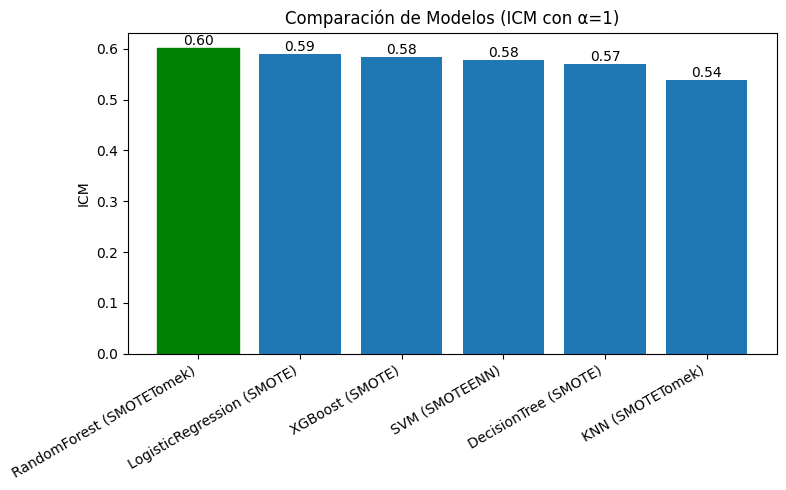

🏆 Mejor modelo: RandomForest
🔹 Balanceo usado: SMOTETomek
🔹 ICM (alpha=1): 0.601432433806992


In [107]:
# Comparación global usando ICM con alpha=1
resultado_final = comparar_mejores_modelos(dic_mejores_modelos_mejorado, alpha=1)

print("🏆 Mejor modelo:", resultado_final['mejor_modelo']['modelo'])
print("🔹 Balanceo usado:", resultado_final['mejor_modelo']['balanceo'])
print("🔹 ICM (alpha=1):", resultado_final['mejor_modelo']['ICM'])

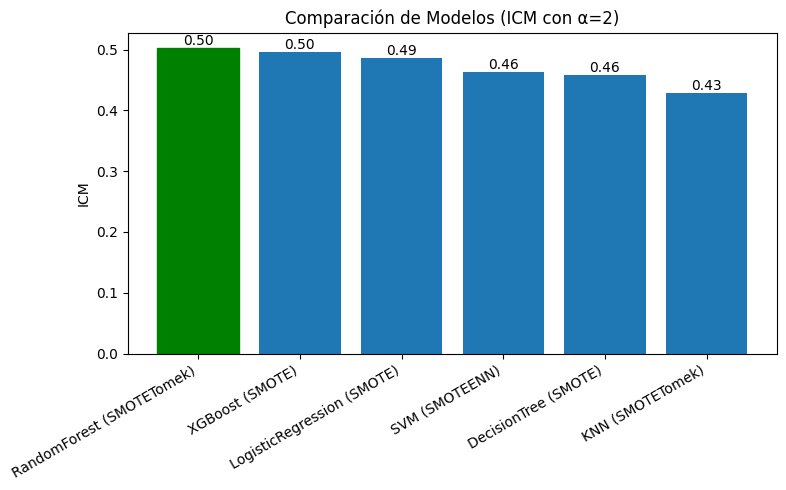

🏆 Mejor modelo: RandomForest
🔹 Balanceo usado: SMOTETomek
🔹 ICM (alpha=2): 0.5024526482519217


In [109]:
# Comparación global usando ICM con alpha=2
resultado_final = comparar_mejores_modelos(dic_mejores_modelos_mejorado, alpha=2)

print("🏆 Mejor modelo:", resultado_final['mejor_modelo']['modelo'])
print("🔹 Balanceo usado:", resultado_final['mejor_modelo']['balanceo'])
print("🔹 ICM (alpha=2):", resultado_final['mejor_modelo']['ICM'])

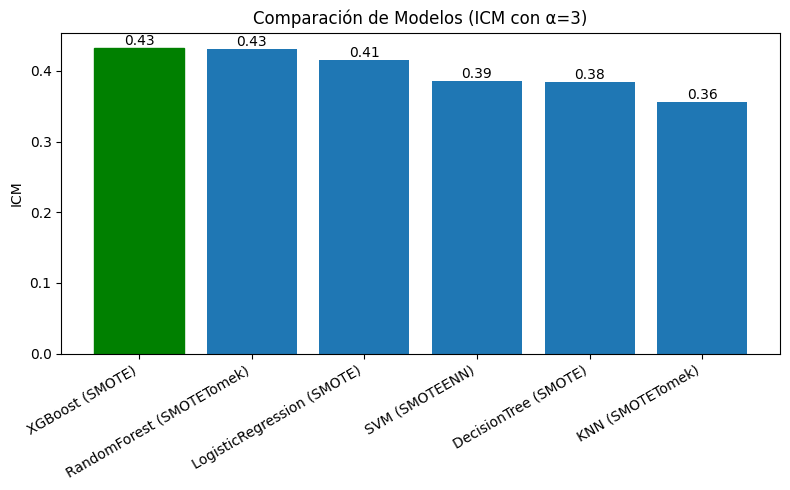

🏆 Mejor modelo: XGBoost
🔹 Balanceo usado: SMOTE
🔹 ICM (alpha=3): 0.4321527431929032


In [108]:
# Comparación global usando ICM con alpha=3
resultado_final = comparar_mejores_modelos(dic_mejores_modelos_mejorado, alpha=3)

print("🏆 Mejor modelo:", resultado_final['mejor_modelo']['modelo'])
print("🔹 Balanceo usado:", resultado_final['mejor_modelo']['balanceo'])
print("🔹 ICM (alpha=3):", resultado_final['mejor_modelo']['ICM'])